In [1]:
from src.ApylabradosModule import Pawns,Word,FrequencyTable,Board,Dictionary
import src.ApylabradosModule as ApylabradosModule
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

¡¡¡Bienvenido al juego Apailabrados de Andres!!!

Instrucciones del juego :
 - Introduce la palabra en Mayuscula
 - La primera palabra siempre debe pasar por la coordenada central
 - A diferencia de la primera palabra, tienes que aprovechar alguna letra para formar la nueva
 - Solo tienes dos opciones para la direccion V (vertical) H (horizontal)



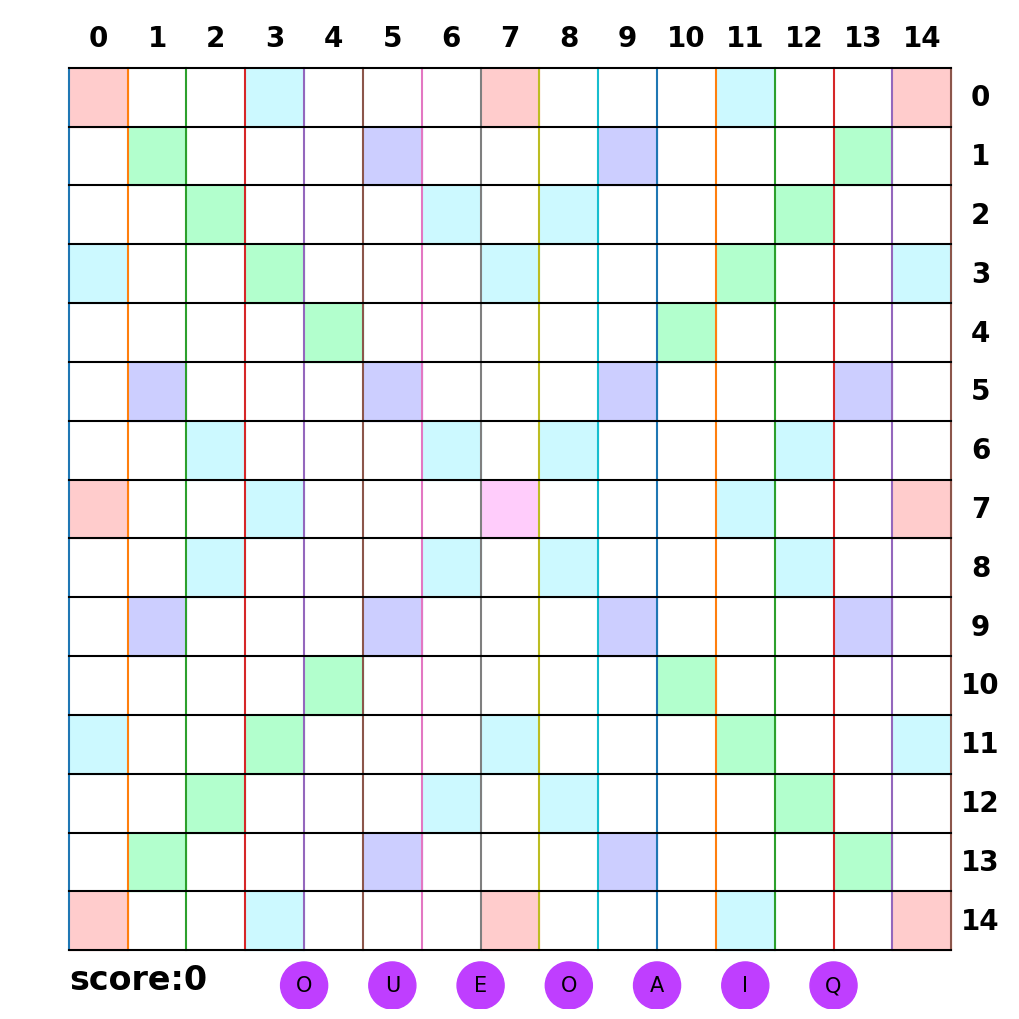

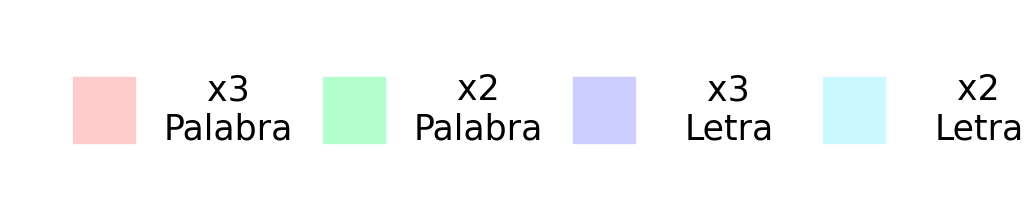

¿Que deseas hacer ?  
 
 Para continuar, introduce: ENTERWORD
 Para consultar fichar, introduce: MYPAWNS
 Para consultar puntos actuales, introduce: MYSCORE
 Para consultar puntos de cada ficha, introduce: PAWNSPOINTS
 Para obtener Ayuda con la posible palabra, introduce: HELPWORD
 Para obtener Ayuda con la Legenda, introduce: HELPLEGEND
 Para Salir del juego, introduce: QUITGAME
 
Fin del Juego
has conseguido 0 de puntos en esta partida


In [2]:
ApylabradosModule.startGame()
while not ApylabradosModule.end and ApylabradosModule.bag_of_pawns.getTotalPawns()>0:
    ApylabradosModule.showOption()
if ApylabradosModule.bag_of_pawns.getTotalPawns()<=0:
    print("¡¡¡Te has quedado sin fichas!!!")
    print("Fin del juego")
print(f"has conseguido {Board.score} de puntos en esta partida")

/Users/andres/Data Science/apailabrado/Proyecto-de-Python/apilabrado/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


¡¡¡Bienvenido al juego Apailabrados de Andres!!!

Instrucciones del juego :
 - Introduce la palabra en Mayuscula
 - La primera palabra siempre debe pasar por la coordenada central
 - A diferencia de la primera palabra, tienes que aprovechar alguna letra para formar la nueva
 - Solo tienes dos opciones para la direccion V (vertical) H (horizontal)



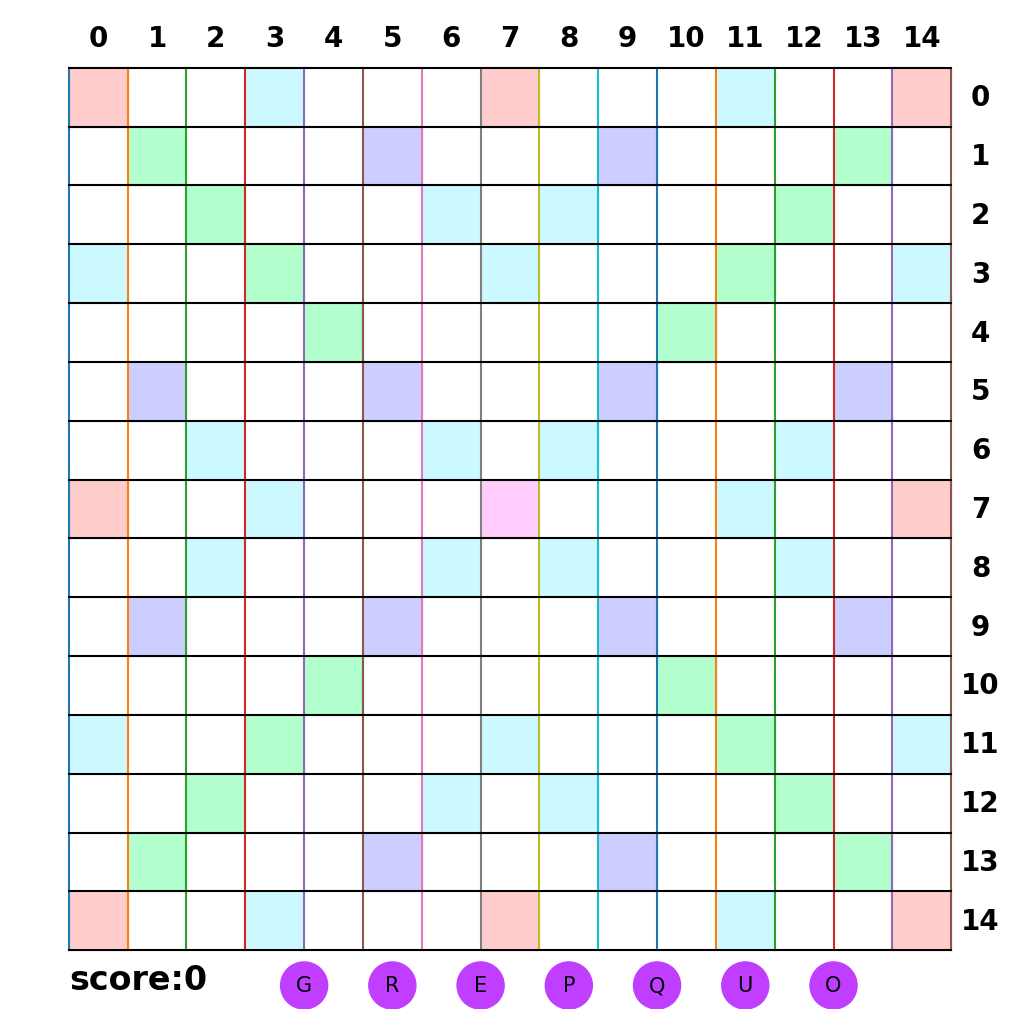

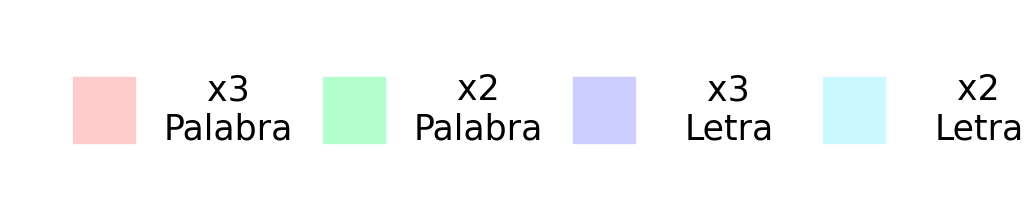

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [1]:
import gradio as gr
import src.ApylabradosModule as ApylabradosModule

# Inicialización del juego
ApylabradosModule.startGame()

def jugar_accion(accion, palabra=None, fila=None, columna=None, direccion=None):
    # Aquí deberías adaptar la lógica para cada acción
    if accion == "ENTERWORD":
        # Validar y colocar palabra
        # Aquí deberías usar palabra, fila, columna y dirección
        return "Palabra colocada (o mensaje de error)", "tablero.png"
    elif accion == "MYPAWNS":
        return "Tus fichas: ...", "tablero.png"
    elif accion == "MYSCORE":
        return f"Puntuación: {ApylabradosModule.Board.score}", "tablero.png"
    elif accion == "PAWNSPOINTS":
        return "Puntos de cada ficha: ...", "tablero.png"
    elif accion == "HELPWORD":
        return "Palabras posibles: ...", "tablero.png"
    elif accion == "HELPLEGEND":
        return "Leyenda del tablero: ...", "tablero.png"
    elif accion == "QUITGAME":
        return "¡Gracias por jugar!", "tablero.png"
    else:
        return "Opción no reconocida", "tablero.png"

with gr.Blocks() as demo:
    gr.Markdown("## Apailabrados")
    with gr.Row():
        accion = gr.Dropdown(
            choices=[
                "ENTERWORD", "MYPAWNS", "MYSCORE", "PAWNSPOINTS",
                "HELPWORD", "HELPLEGEND", "QUITGAME"
            ],
            label="¿Qué deseas hacer?"
        )
    with gr.Row():
        palabra = gr.Textbox(label="Palabra (si aplica)", visible=False)
        fila = gr.Number(label="Fila (si aplica)", visible=False)
        columna = gr.Number(label="Columna (si aplica)", visible=False)
        direccion = gr.Dropdown(choices=["V", "H"], label="Dirección (si aplica)", visible=False)
    salida = gr.Textbox(label="Salida")
    tablero = gr.Image(value="tablero.png", label="Tablero")
    btn = gr.Button("Enviar")

    # Mostrar u ocultar campos según la acción seleccionada
    def mostrar_campos(accion):
        if accion == "ENTERWORD":
            return {palabra: gr.update(visible=True),
                    fila: gr.update(visible=True),
                    columna: gr.update(visible=True),
                    direccion: gr.update(visible=True)}
        else:
            return {palabra: gr.update(visible=False),
                    fila: gr.update(visible=False),
                    columna: gr.update(visible=False),
                    direccion: gr.update(visible=False)}

    accion.change(mostrar_campos, inputs=accion, outputs=[palabra, fila, columna, direccion])
    btn.click(jugar_accion, inputs=[accion, palabra, fila, columna, direccion], outputs=[salida, tablero])

demo.launch()

In [5]:
with gr.Blocks() as demo:
    gr.Markdown("## Apailabrados")
    with gr.Row():
        # Columna izquierda: interacción
        with gr.Column(scale=1):
            accion = gr.Dropdown(
                choices=[
                    "ENTERWORD", "MYPAWNS", "MYSCORE", "PAWNSPOINTS",
                    "HELPWORD", "HELPLEGEND", "QUITGAME"
                ],
                label="¿Qué deseas hacer?"
            )
            palabra = gr.Textbox(label="Palabra (si aplica)", visible=False)
            fila = gr.Number(label="Fila (si aplica)", visible=False)
            columna = gr.Number(label="Columna (si aplica)", visible=False)
            direccion = gr.Dropdown(choices=["V", "H"], label="Dirección (si aplica)", visible=False)
            btn = gr.Button("Enviar")
            salida = gr.Textbox(label="Salida")
        # Columna derecha: tablero
        with gr.Column(scale=2):
            tablero = gr.Image(value="images/apayla.png", label="Tablero")

    # Mostrar u ocultar campos según la acción seleccionada
    def mostrar_campos(accion):
        if accion == "ENTERWORD":
            return {palabra: gr.update(visible=True),
                    fila: gr.update(visible=True),
                    columna: gr.update(visible=True),
                    direccion: gr.update(visible=True)}
        else:
            return {palabra: gr.update(visible=False),
                    fila: gr.update(visible=False),
                    columna: gr.update(visible=False),
                    direccion: gr.update(visible=False)}

    accion.change(mostrar_campos, inputs=accion, outputs=[palabra, fila, columna, direccion])
    btn.click(jugar_accion, inputs=[accion, palabra, fila, columna, direccion], outputs=[salida, tablero])

demo.launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


In [7]:
with gr.Blocks() as demo:
    with gr.Tab("Lion"):
        gr.Image("lion.jpg")
        gr.Button("New Lion")
    with gr.Tab("Tiger"):
        gr.Image("tiger.jpg")
        gr.Button("New Tiger")
demo.launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
